# Introduction

The objective of this project is to develop a predictive model that estimates the mortality risk of patients based on their clinical data. Such a tool can assist doctors in making informed decisions about whether a patient requires hospitalization or can be safely discharged. In addition to providing accurate predictions, the project emphasizes interpretability: by identifying which features contribute most to the risk assessment, we aim to highlight the clinical factors that deserve the closest attention.

# Import libraries

In [58]:
import pandas as pd 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import backend as K
import duckdb

In [2]:
import importlib
import models 
import preprocessing

importlib.reload(models)
importlib.reload(preprocessing)
from models import logistic_regression, display_metrics, display_metrics_logistic_regression_k_times, display_metrics_xgboost_k_times, display_metrics_knn_k_times
from preprocessing import preprocess_data, fillna_and_encode

# Import df

In [100]:
df = pd.read_csv('support2.csv')

# X, y 

In [101]:
X = df.drop(columns=["hospdead"])
y = df["hospdead"]

# Exploring the data

In [87]:
X.columns

Index(['age', 'death', 'sex', 'slos', 'd.time', 'dzgroup', 'dzclass', 'num.co',
       'edu', 'income', 'scoma', 'charges', 'totcst', 'totmcst', 'avtisst',
       'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday', 'diabetes',
       'dementia', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday', 'meanbp', 'wblc',
       'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
       'glucose', 'bun', 'urine', 'adlp', 'adls', 'sfdm2', 'adlsc'],
      dtype='object')

In [42]:
y.value_counts()

hospdead
0    6745
1    2360
Name: count, dtype: int64

These values were deleted while reading the documentation that can be found at https://www.kaggle.com/datasets/joebeachcapital/support2 

In [102]:
columns_to_drop = [
    "aps", "sps", "surv2m", "surv6m", "prg2m", "prg6m",
    "dnr", "dnrday", "slos", "death", "d.time", "adls", "adlp",
    "dzclass", "scoma", "hday", "totcst", "charges", "totmcst"
]

X1 = X.drop(columns=columns_to_drop)

In [76]:
X1.describe()

,age,num.co,edu,avtisst,diabetes,dementia,meanbp,wblc,hrt,resp,...,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlsc
count,9105.000000,9105.000000,7471.000000,9023.000000,9105.000000,9105.000000,9104.000000,8893.000000,9104.000000,9104.000000,...,6780.000000,5733.000000,6504.000000,9038.000000,9104.000000,6821.000000,4605.000000,4753.000000,4243.000000,9105.000000
mean,62.650823,1.868644,11.747691,22.610928,0.195277,0.032510,84.546408,12.347677,97.156711,23.330294,...,239.529070,2.950520,2.554463,1.770961,137.568541,7.415364,159.873398,32.349463,2191.546047,1.888272
std,15.593710,1.344409,3.447743,13.233248,0.396436,0.177359,27.687692,9.266329,31.559292,9.573801,...,109.665593,0.875944,5.318448,1.686041,6.029326,0.080563,88.391541,26.792288,1455.245777,2.003763
min,18.041990,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.000000,0.399963,0.099991,0.099991,110.000000,6.829102,0.000000,1.000000,0.000000,0.000000
25%,52.797000,1.000000,10.000000,12.000000,0.000000,0.000000,63.000000,7.000000,72.000000,18.000000,...,155.093750,2.399902,0.500000,0.899902,134.000000,7.379883,103.000000,14.000000,1165.500000,0.000000
50%,64.856990,2.000000,12.000000,19.500000,0.000000,0.000000,77.000000,10.599609,100.000000,24.000000,...,224.000000,2.899902,0.899902,1.199951,137.000000,7.419922,135.000000,23.000000,1968.000000,1.000000
75%,73.998960,3.000000,14.000000,31.666656,0.000000,0.000000,107.000000,15.298828,120.000000,28.000000,...,304.750000,3.599609,1.899902,1.899902,141.000000,7.469727,188.000000,42.000000,3000.000000,3.000000
max,101.847960,9.000000,31.000000,83.000000,1.000000,1.000000,195.000000,200.000000,300.000000,90.000000,...,890.375000,29.000000,63.000000,21.500000,181.000000,7.769531,1092.000000,300.000000,9000.000000,7.073242


In [77]:
corr = X1["hrt"].corr(X1["resp"])
print(corr)

0.21210194130669488


## Hrt

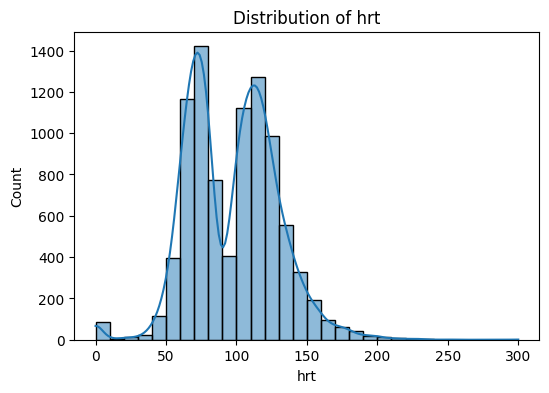

In [73]:
plt.figure(figsize=(6,4))
sns.histplot(X["hrt"], bins=30, kde=True)  # kde=True adds a smooth density curve
plt.title("Distribution of hrt")
plt.show()

## Edu

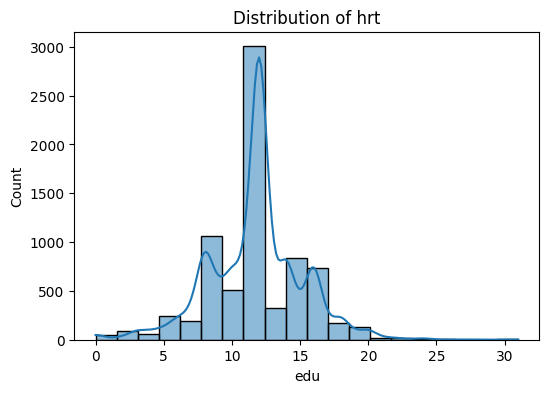

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(X["edu"], bins=20, kde=True)  # kde=True adds a smooth density curve
plt.title("Distribution of edu")
plt.show()

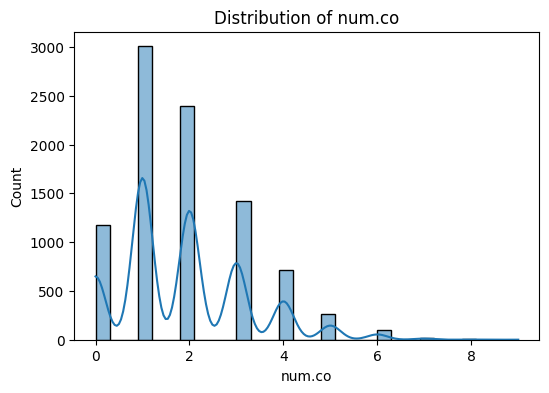

In [65]:
plt.figure(figsize=(6,4))
sns.histplot(X["num.co"], bins=30, kde=True)  # kde=True adds a smooth density curve
plt.title("Distribution of num.co")
plt.show()

In [64]:
result = duckdb.query(
    """ 
            SELECT avg(hospdead), "num.co"
            FROM df 
            GROUP BY "num.co" 
            ORDER BY avg(hospdead) DESC
    """
)

print(result)

┌─────────────────────┬────────┐
│    avg(hospdead)    │ num.co │
│       double        │ int64  │
├─────────────────────┼────────┤
│   0.324553950722175 │      0 │
│ 0.27478376580172986 │      1 │
│  0.2565707133917397 │      2 │
│ 0.23193916349809887 │      5 │
│ 0.21894736842105264 │      3 │
│  0.2030812324929972 │      4 │
│ 0.17346938775510204 │      6 │
│ 0.09523809523809523 │      7 │
│                 0.0 │      9 │
│                 0.0 │      8 │
├─────────────────────┴────────┤
│ 10 rows            2 columns │
└──────────────────────────────┘



## Avtisst

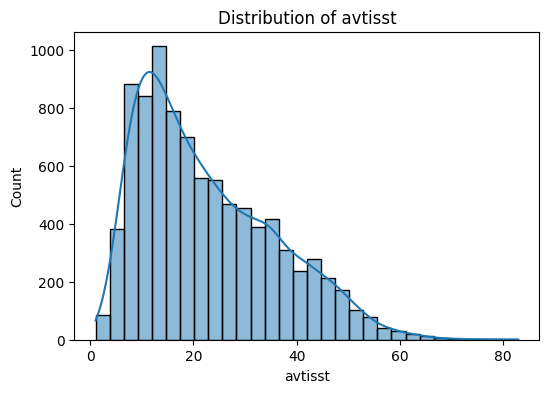

In [66]:
plt.figure(figsize=(6,4))
sns.histplot(X["avtisst"], bins=30, kde=True)  # kde=True adds a smooth density curve
plt.title("Distribution of avtisst")
plt.show()

## sfdm2

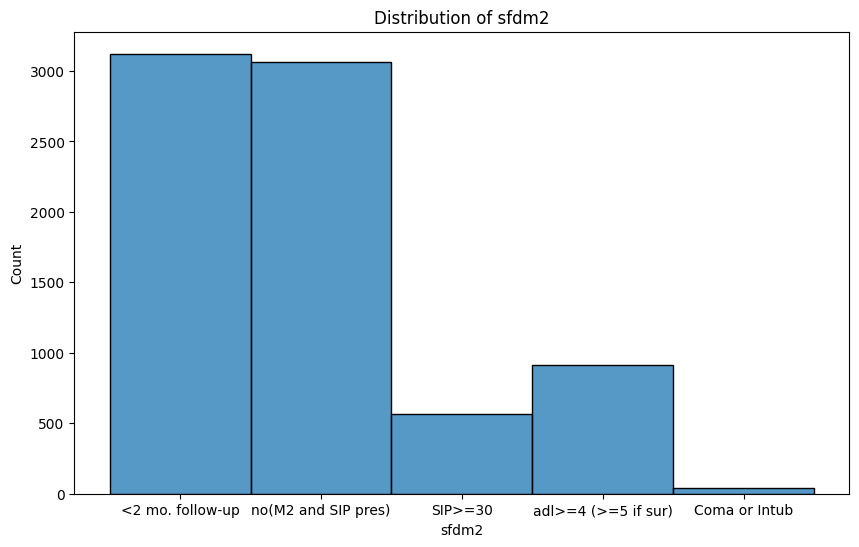

In [72]:
plt.figure(figsize=(10,6))
sns.histplot(X["sfdm2"], bins=30, kde=False)  # kde=True adds a smooth density curve
plt.title("Distribution of sfdm2")
plt.show()

In [71]:
result_sfdm2 = duckdb.query(
    """ 
                        SELECT avg(hospdead), sfdm2
                        FROM df 
                        GROUP BY sfdm2 
                        ORDER BY avg(hospdead) DESC
                            
    """
)

print(result_sfdm2)

┌───────────────────────┬─────────────────────┐
│     avg(hospdead)     │        sfdm2        │
│        double         │       varchar       │
├───────────────────────┼─────────────────────┤
│    0.7239833493435799 │ <2 mo. follow-up    │
│   0.17073170731707318 │ Coma or Intub       │
│  0.056768558951965066 │ adl>=4 (>=5 if sur) │
│  0.023571428571428573 │ NULL                │
│ 0.0070921985815602835 │ SIP>=30             │
│ 0.0009800718719372753 │ no(M2 and SIP pres) │
└───────────────────────┴─────────────────────┘



A clear analysis here would be that knowing if a patient has a "2 mo. follow up" for sfdm2, the chances are really high he dies.

# First dataframe

## Preprocessing

The author of the paper the dataset is originated from explains that for certains columns we can replace missing values by default values, for this dataset we consider deleting also glucose and income

In [103]:
X1.fillna({
    "bun": 6.51,
    "pafi": 333.3,
    "alb": 3.5,
    "bili": 1.01,
    "wblc": 9,
    "urine": 2502,
    "crea": 1.01
}, inplace=True)

X1.drop(columns=["glucose", "income"], inplace=True)

Now we are going to see how to replace missing values 

In [104]:
categorical_variables = [
    "diabetes","dementia","sex","race","dzgroup","ca","sfdm2","num.co", "edu"
]

In [105]:
X1_categorical = X1[categorical_variables]
X1_numerical = X1.drop(columns=categorical_variables)

For categorical, we are going to replace missing values with the most present category.

For numerical, we are going to replace missing values with the mean. 

In [ ]:

for col in X1_categorical.columns:
    # Find the most frequent value in the column
    most_frequent = X1_categorical[col].value_counts().idxmax()
    # Fill NaNs with the most frequent value
    X1_categorical[col] = X1_categorical[col].fillna(most_frequent)

X1_categorical = pd.get_dummies(X1_categorical, drop_first=True)


In [108]:
X1_categorical.isna().sum().sum()  

0

### Dealing with numerical missing values with the mean

In [107]:
X1_numerical.columns

Index(['age', 'avtisst', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi',
       'alb', 'bili', 'crea', 'sod', 'ph', 'bun', 'urine', 'adlsc'],
      dtype='object')

In [109]:
X1_numerical.fillna(df.mean(numeric_only=True), inplace=True)


sc = StandardScaler()
X1_numerical = pd.DataFrame(
    sc.fit_transform(X1_numerical),
    columns=X1_numerical.columns,
    index=X1_numerical.index 
)


In [13]:
X1_numerical.isna().sum().sum() 

0

### Merging

In [110]:
X1_cleaned = pd.concat([X1_numerical, X1_categorical], axis=1)

No more missing values

In [15]:
X1_cleaned.isna().sum().sum()

0

## Models

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X1_cleaned, y, test_size=0.2, random_state=42)

### Logistic regression

In [16]:
display_metrics_logistic_regression_k_times(X1_cleaned, y, k=5)

Accuracy: 0.890 ± 0.007 (SD over 5 runs)
Precision: 0.792 ± 0.010 (SD over 5 runs)
Recall: 0.763 ± 0.024 (SD over 5 runs)
F1 Score: 0.777 ± 0.013 (SD over 5 runs)


We can conclude than the model does not rely too much on the data and does not overfit, therefore to see which features matter the most, we are going to use the prediction for one X_train, y_train, X_test, y_test

#### Analysis

In [ ]:
LR, y_pred = logistic_regression(X_train, X_test, y_train)

Accuracy: 0.9
Precision: 0.82
Recall: 0.76
F1 Score: 0.79


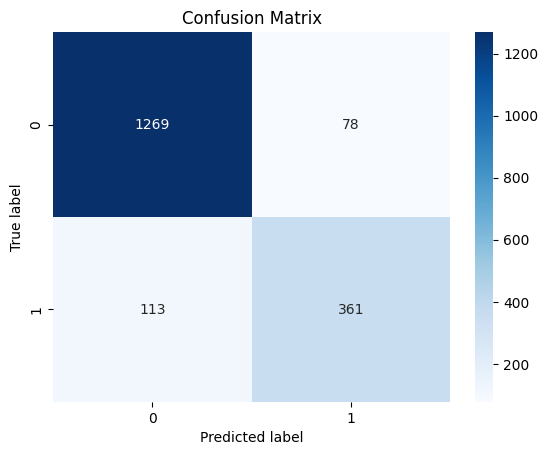

In [18]:
display_metrics(y_test, y_pred)

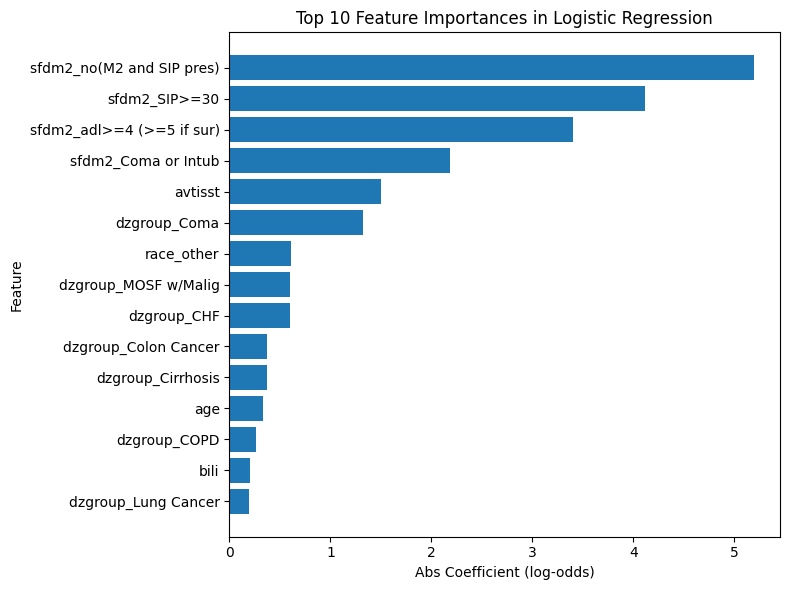

In [19]:
coefs = LR.coef_[0]

feature_names = X_train.columns

# Here we create a DataFrame to hold feature names and their corresponding coefficients
importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs),
    "odds_ratio": np.exp(coefs)
}).sort_values("abs_coefficient", ascending=False)

top_features = importance.head(15)

plt.figure(figsize=(8,6))
plt.barh(top_features['feature'], top_features['abs_coefficient'])
plt.xlabel("Abs Coefficient (log-odds)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances in Logistic Regression")
plt.gca().invert_yaxis()  # highest coefficient on top
plt.tight_layout()
plt.show()

What we can first see is that the initial variable sfdm2 (corresponding to the degree of disability of the patient) is the most important, followed by avtisst (corresponding to an estimation of the cost of the patient's treatment)

### Random forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Hyperparameters: {'n_estimators': 100, 'max_depth': 25}
Accuracy: 0.9
Precision: 0.83
Recall: 0.75
F1 Score: 0.79


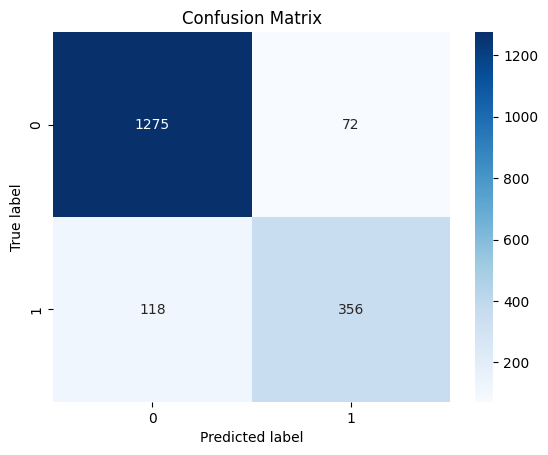

In [26]:
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions={
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'max_depth': [None, 5, 10, 15, 20, 25, 30],

    },
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
    )

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)


best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
display_metrics(y_test, y_pred)

Accuracy: 0.89
Precision: 0.82
Recall: 0.74
F1 Score: 0.78


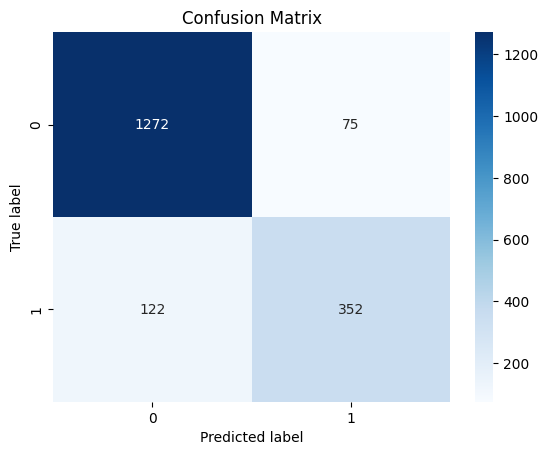

In [20]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None, 
    n_jobs=-1          # use all CPUs
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

display_metrics(y_test, y_pred)

#### Analysis

In [21]:
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": rf.feature_importances_
}).sort_values("coefficient", ascending=False)

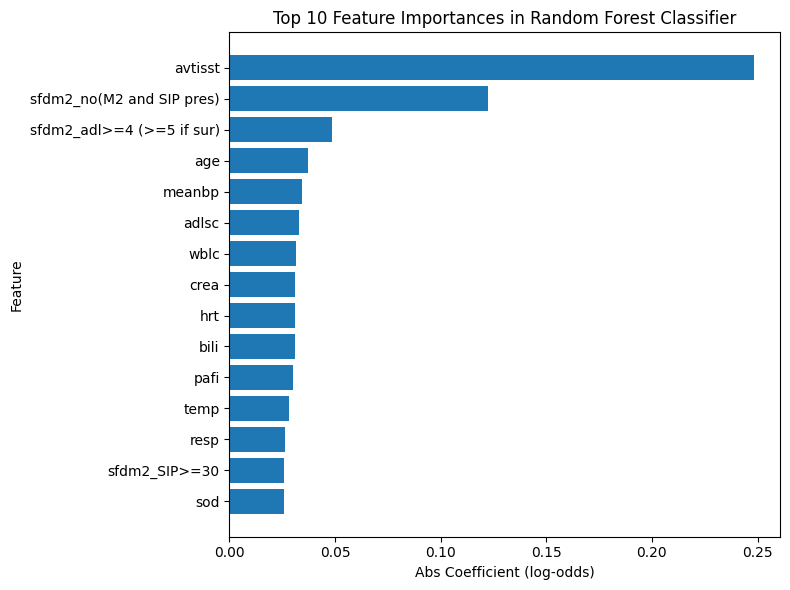

In [22]:
top_features = importance_df.head(15)

plt.figure(figsize=(8,6))
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel("Abs Coefficient (log-odds)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances in Random Forest Classifier")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

Here for the random classifier, avtisst is the most important variable

##### Shap (give precious insights but takes a lot of time to execute)

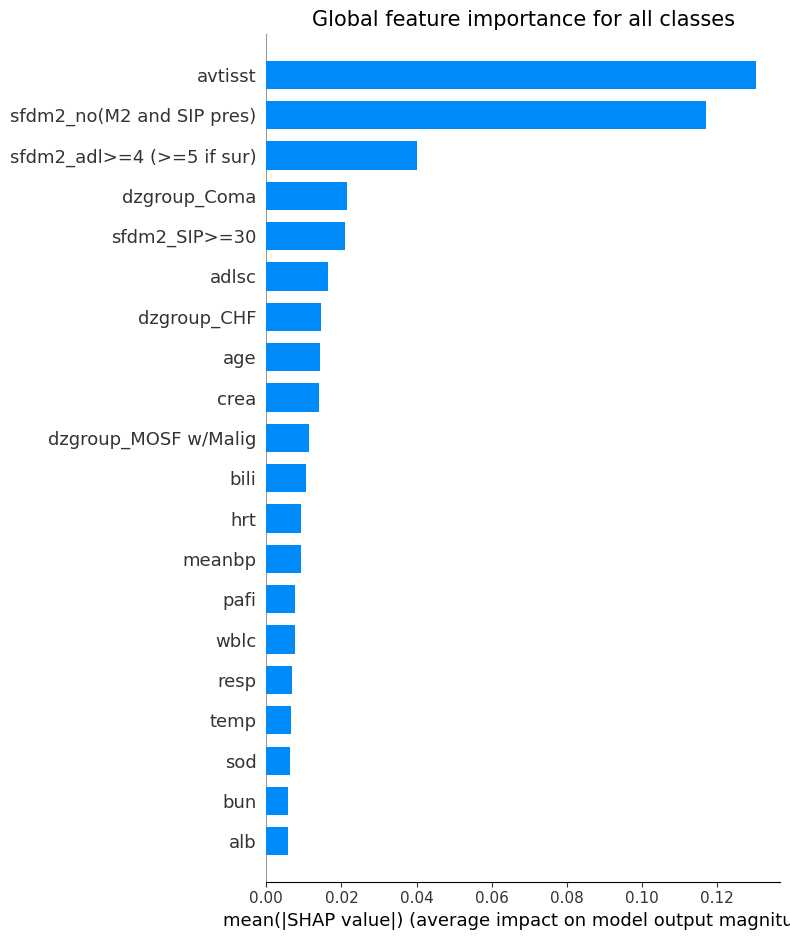

In [ ]:
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_train)

# Average SHAP values across classes
shap_values_mean = np.abs(shap_values).mean(axis=2)

# Plot global feature importance for all classes
plt.title("Global feature importance for all classes", fontsize=15)
shap.summary_plot(shap_values_mean, X_train, feature_names=X_train.columns, plot_type="bar")



##### Permutation importance (we shuffle the columns to see which variables has the most impact)

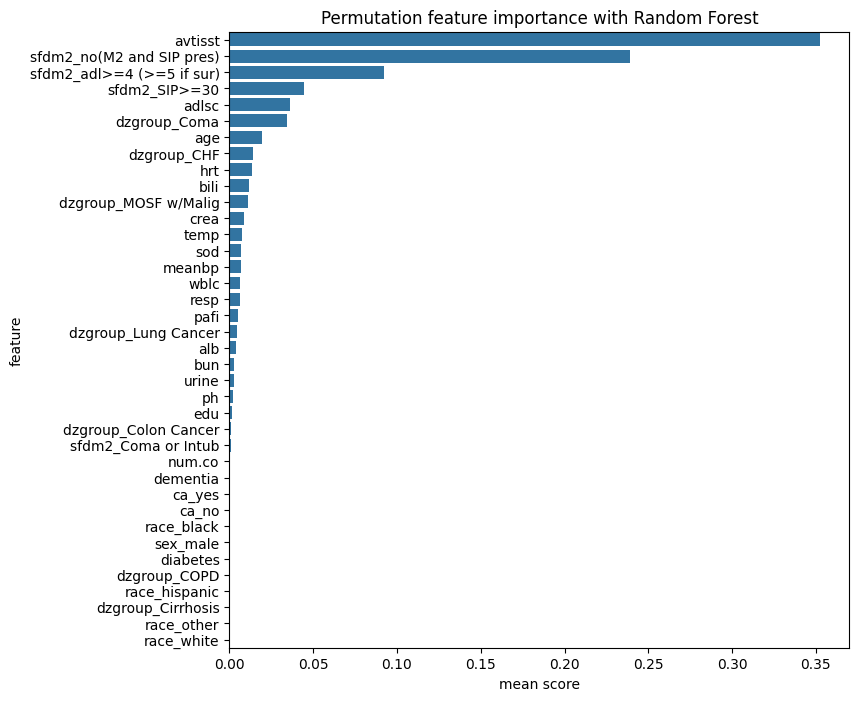

In [ ]:
# Compute permutation importance for each feature using a f1 score
permutation_score = permutation_importance(rf, X_train, y_train, n_repeats=30, scoring="f1", random_state=0) # n_repeats: number of times data is reshuffled


permutation_df = pd.DataFrame({"feature":X_train.columns,
                               "mean score":permutation_score.importances_mean,
                               "std":permutation_score.importances_std}).sort_values("mean score", ascending=False)


plt.figure(figsize=(8,8))
sns.barplot(data = permutation_df, x="mean score", y="feature")
plt.title("Permutation feature importance with Random Forest")
plt.show()

For this model, the features that matter the most are again sfdm2, avtisst, adlsc (indicates the chance of survival at day 3) 

### XGBoost

Here, we are going to use a RandomizedSearchCV to get the best hyperparameters for our xgboost model

In [23]:

xgb_clf = XGBClassifier(
    random_state=100,
    eval_metric='logloss'
)


param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=250,          # here we choose a big number to try a lot of combinations 
    scoring="f1",        
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=100
)


random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", round(random_search.best_score_, 3))

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.07, 'colsample_bytree': 0.8}
Best F1 score: 0.785


Here are the best parameters

In [24]:
bp = random_search.best_params_
subsample = bp['subsample']
colsample_bytree = bp['colsample_bytree']
n_estimators = bp['n_estimators']
learning_rate = bp['learning_rate']
max_depth = bp['max_depth']

Accuracy: 0.9
Precision: 0.83
Recall: 0.78
F1 Score: 0.8


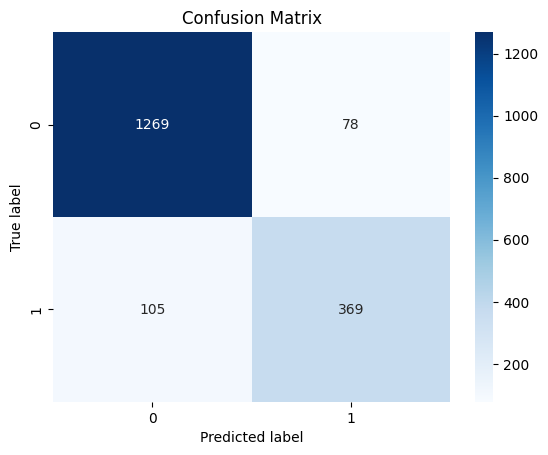

In [25]:
# Define model
xgb_clf = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,          
    subsample=subsample,       
    colsample_bytree=colsample_bytree, 
    random_state=100,
    eval_metric='logloss' 
)

# Fit model
xgb_clf.fit(X_train, y_train)

# Predict
y_pred = xgb_clf.predict(X_test)

display_metrics(y_test, y_pred)


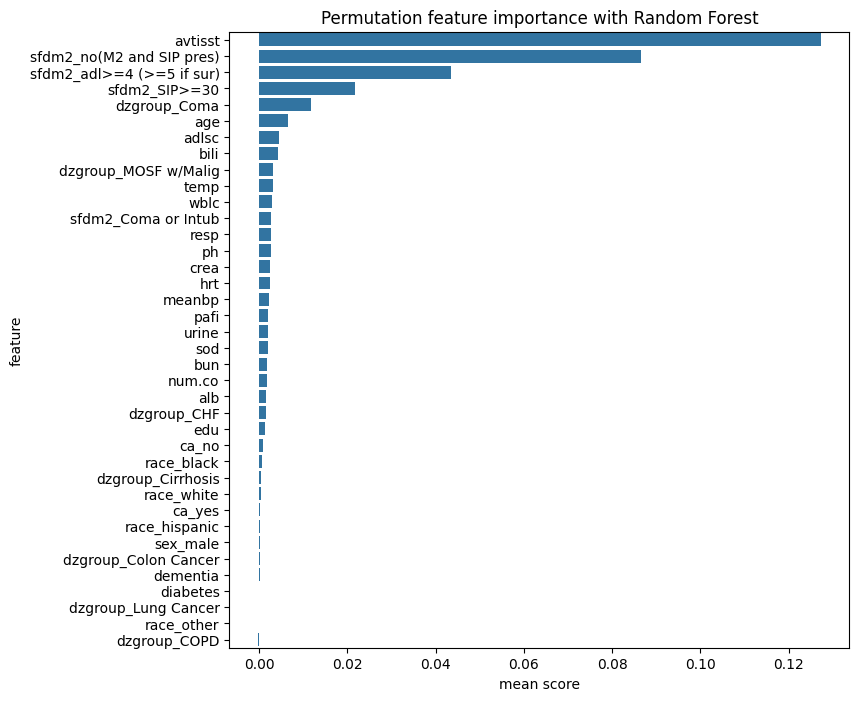

In [ ]:


# Compute permutation importance for each feature using a f1 score
permutation_score = permutation_importance(xgb_clf, X_train, y_train, n_repeats=30, scoring="accuracy", random_state=0)


permutation_df = pd.DataFrame({"feature":X_train.columns,
                               "mean score":permutation_score.importances_mean,
                               "std":permutation_score.importances_std}).sort_values("mean score", ascending=False).head(15)


plt.figure(figsize=(8,8))
sns.barplot(data = permutation_df, x="mean score", y="feature")
plt.title("Permutation feature importance with XGBoost")
plt.show()

We obtain again sfdm2 different categories and avtisst as the features that matter the most.

### KNN

Accuracy: 0.79
Precision: 0.61
Recall: 0.49
F1 Score: 0.55


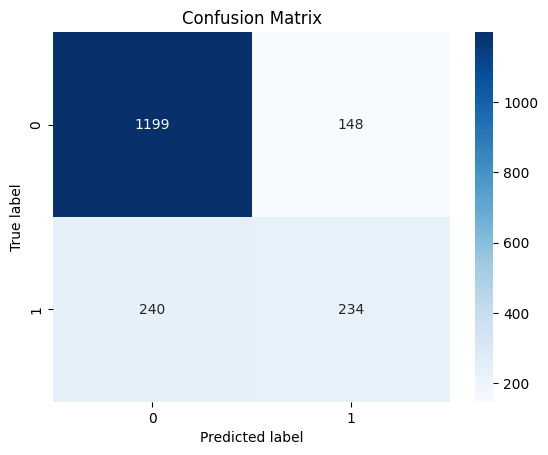

In [26]:

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

knn.fit(X_train, y_train)   

y_pred = knn.predict(X_test)     


display_metrics(y_test, y_pred)

### SVM

In [24]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear','poly']
}

grid = GridSearchCV(
    SVC(),
    param_grid, 
    refit=True, 
    cv=5, 
    scoring='f1')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.7834125223355438


Accuracy: 0.89
Precision: 0.81
Recall: 0.76
F1 Score: 0.78


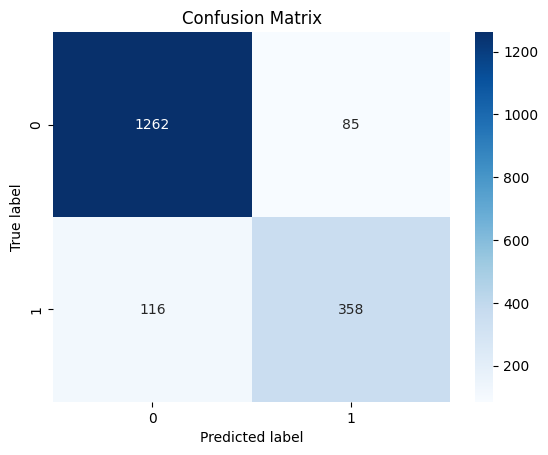

In [27]:
svc = SVC(
    C= 100, 
    gamma=0.001, 
    kernel='rbf'
)

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

display_metrics(y_test=y_test, y_pred=y_pred)

### Comparison

In [28]:
classifiers = {"knn" : knn,
               "logistic_regression" : LR,
               "random_forest" : rf,
               "xgboost_classifier" : xgb_clf, 
               "svc" : svc}

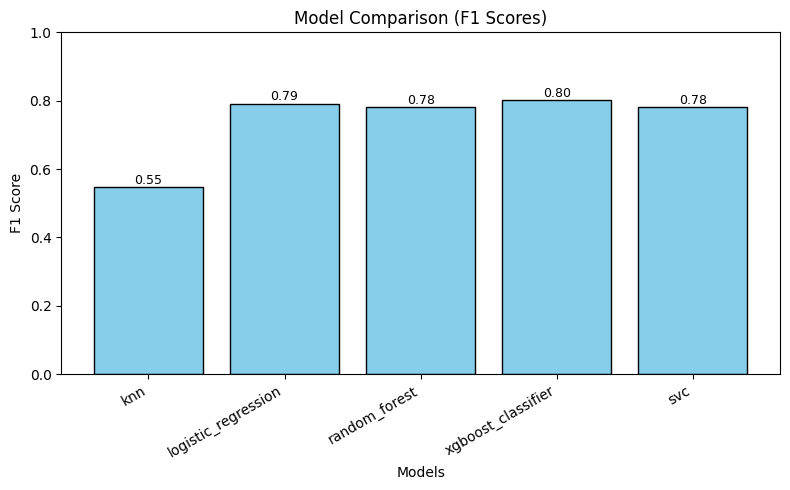

In [29]:
f1_scores = {}
for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[name] = f1


# Extract keys and values
models = list(f1_scores.keys())
scores = list(f1_scores.values())

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, scores, color="skyblue", edgecolor="black")

# Add labels and title
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("Model Comparison (F1 Scores)")
plt.ylim(0, 1)  # since F1 scores go from 0 to 1
plt.xticks(rotation=30, ha="right")

# Annotate bars with values
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

## Conclusion

These models confirm all that the most important features are sfdm2 and avtisst, therefore these measures must be taken by doctors, nurses around the patient. 
The logistic regression, random forest and xgboost all gives approximately the f1 score, so for better explainibilty if we want to give daily reports to doctors, it might be better to use logistic regression that is easier to interpret.

In the next part, we will try different imputation to see if this increaeses our model performance

# Second dataframe

For this one, we will try to work more on the data we have

In [315]:
X2 = X

## Preprocessing

For this df, we decide to to gather the features edu and age by group instead of having long int

In [341]:
X2 = preprocess_data(X2)

### Age

In [342]:
X2["age"].describe()

count    9105.000000
mean       62.650823
std        15.593710
min        18.041990
25%        52.797000
50%        64.856990
75%        73.998960
max       101.847960
Name: age, dtype: float64

In [343]:
# Define bins
bins = [0, 30, 40, 50, 60, 70, 80, 90, float("inf")]
labels = ["0-30", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90+"]

# Apply binning
X2["age_group"] = pd.cut(X2["age"], bins=bins, labels=labels, right=False)

### Edu

In [ ]:
# Define bins and labels
bins = [0, 5, 8, 13, 16, 18, 22, 30]  # edges in years
labels = [
    "Pre-school / early years",
    "Middle school",
    "High school",
    "Associate degree / some college",
    "Bachelor's degree",
    "Master's degree",
    "Doctorate / Professional degree"
]

X2["edu_group"] = pd.cut(X2["edu"], bins=bins, labels=labels, right=False)


In [349]:
X2.drop(columns=["age", "edu"], inplace=True)

### Categorical variables 2

In [358]:
categorical_variables2 = [
    "diabetes","dementia","sex","race","dzgroup","ca","sfdm2","num.co", "age_group", "edu_group"
]

X2_cleaned = fillna_and_encode(X2,categorical_variables2)

In [359]:
display_metrics_logistic_regression_k_times(X2_cleaned, y, k=5)

Accuracy: 0.887 ± 0.007 (SD over 5 runs)
Precision: 0.792 ± 0.016 (SD over 5 runs)
Recall: 0.753 ± 0.023 (SD over 5 runs)
F1 Score: 0.772 ± 0.019 (SD over 5 runs)


## X, y

In [363]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_cleaned, y, test_size=0.2)

## Models

Accuracy: 0.88
Precision: 0.81
Recall: 0.7
F1 Score: 0.75


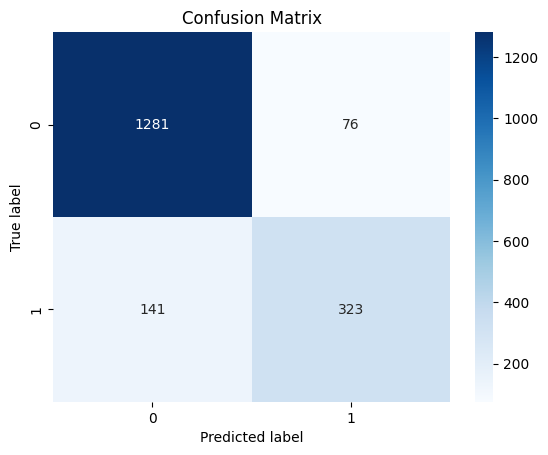

In [364]:
# Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=500,  # number of trees
    max_depth=None,    # allow full growth
    random_state=42,
    n_jobs=-1          # use all CPUs
)
rf.fit(X2_train, y2_train)

# Predict
y2_pred = rf.predict(X2_test)

# Optional: check accuracy
display_metrics(y2_test, y2_pred)

In [365]:

xgb_clf = XGBClassifier(
    random_state=100,
    eval_metric='logloss'
)


param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=250,          # here we choose a big number to try a lot of combinations 
    scoring="f1",        
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=100
)

# Fit random search
random_search.fit(X2_train, y2_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.09, 'colsample_bytree': 0.8}
Best F1 score: 0.7907348100327635
